# Game Dry Run

## Weapon Generator API 
The code is almost the same as the code used in the weapon_generator_api.py file. It works the same but doesn't look the same in every section. Please take a look at the code in the engine.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import variational_autoencoder as vae
import weapon_data as weapons

from tensorflow.python.framework import random_seed

import matplotlib.pyplot as plt
%matplotlib inline

class tfPlugin:
    def __init__(self):
        self._sess = None
        self._vae = None
        self.trained_model_save_folder = "trained_vae/"
        self.training_data_source = "training_data.csv"
        self.test_data_source = "test_data.csv"
        
    def onSetup(self):
        self._random_seed = 19071991
        seed, _ = random_seed.get_seed(self._random_seed)
        np.random.seed(seed)
        
        self.shouldStop = False
        
        self._train_data, self._test_data = weapons.get_data(self.training_data_source, self.test_data_source, seed=self._random_seed)

        #set training parameter
        self._network_architecture = \
            dict(n_input=self._train_data.num_features,
                 n_hidden_1=26,
                 n_hidden_2=12,
                 n_z=2)  
        self._batch_size = 4
        self._learning_rate = 0.01
        self._optimizer = tf.train.RMSPropOptimizer(self._learning_rate)
        self._transfer_fct = tf.nn.elu
        self._num_training_epochs = 100
        
        #keep track of the received and dismantled weapons 
        self._dismantled_weapons = []
        
        #amount of dismantles models needed to retrain the model
        self._dismantled_weapons_needed_to_retrain = 20
        
        #start session is realized in on begin training and will be swaped with the tmp afterwards
        self._sess = None
        self._vae = None
        
        self._trained_model_available = False
        self._trained_model_path = ""
        
    def onJsonInput(self, jsonInput):
        if self._trained_model_available:
            self.__load_trained_model()
            
        if self._vae == None:
            print("ERROR: there is no trained model?!")
            return {}
        
        if not bool(jsonInput):
            print("ERROR: empty input!")
            return {}
        
        generated_weapon = []
        
        #encode the json input to a standardized weapon data
        encoded_json_input = self.__encode_json_input_to_a_standardized_train_data_format(jsonInput)
        #check if the encoded data should be used to generate a new one 
        #calculate loss requires a batch which has the size of the trained model batch_size
        batch = [encoded_json_input[0] for _ in range(self._batch_size)]
        generation_cost = self._vae.calculate_loss(batch)
        generation_cost /= self._batch_size

        #if the cost is too high, then just generate a random one
        #a too high value means that the VAE don't know which weapon that should be!
        if generation_cost >= 50 or np.isnan(generation_cost) or np.isinf(generation_cost):
            generated_weapon = self.__generate_random_weapons(1)
            print("Generated a random weapon!")
        else:
            generated_weapon = self._vae.encode_and_decode(encoded_json_input, False)
            print("Generated a new weapon based on a dismantled one!")

        if len(generated_weapon) <= 0:
            print("ERROR: no generated weapon?!")
            return {}
        
        #do it afterwards so that crazy weapons don't destroy the model
        self.__add_received_dismantled_weapon(encoded_json_input[0])
        
        result, _ = self._train_data.decode_processed_tensor(generated_weapon[0])
        return result
        
    def onBeginTraining(self):
        with tf.Session() as sess:

            #add the dismantled weapons so that the model emerges in a direction
            if len(self._dismantled_weapons) > 0:
                self._train_data.add_new_weapons_and_restandardize_data(self._dismantled_weapons)
                self._dismantled_weapons = []
                self._num_training_epochs += 10

            network = vae.get_untrained(sess, self._network_architecture, self._optimizer, 
                                      self._transfer_fct, self._batch_size)

            num_samples = self._train_data.num_examples
            print("Num of training samples = %i" %num_samples)
            
            #is basically the same code from the VAE file
            #training cycle
            for epoch in range(self._num_training_epochs):
                avg_cost = 0.
                total_batch = int(num_samples / self._batch_size)

                # Loop over all batches
                for _ in range(total_batch):
                    batch = self._train_data.next_batch(self._batch_size)

                    # Fit training using batch data
                    cost = network.train_with_mini_batch(batch)

                    #compute average loss/cost
                    avg_cost += cost / num_samples * self._batch_size

                # Display logs per epoch step
                if (epoch+1) % 10 == 0:
                    print("Epoch:"+ '%04d' % (epoch+1) + " - Cost:" + "{:.2f}".format(avg_cost))

                if self.shouldStop:
                    break;

            self._trained_model_path = network.save_trained_model(self.trained_model_save_folder)
            self._trained_model_available = True
        
        
    def onStopTraining(self):
        if self._sess:
            self._sess.close()
        
    def __load_trained_model(self):
        if self._sess:
            self._sess.close()
        tf.reset_default_graph()
    
        self._sess = tf.Session(graph=tf.get_default_graph())
        self._vae = vae.get_untrained(self._sess, self._network_architecture, self._optimizer, 
                                  self._transfer_fct, self._batch_size)
        self._vae = vae.restore(self._vae, self._trained_model_path)
        self._trained_model_available = False
        
    def __encode_json_input_to_a_standardized_train_data_format(self, json_input):
        prepared_for_encoding = self._train_data.prepare_decoded_tensor_dict_for_encoding(json_input)
        encoded, _ = self._train_data.encode_features_dict(prepared_for_encoding)
        encoded_standardized = self._train_data.standardize_encoded_data(encoded[0])
        return [encoded_standardized]
    
    def __add_received_dismantled_weapon(self, weapon):
        self._dismantled_weapons.append(weapon)
        
        if len(self._dismantled_weapons) >= self._dismantled_weapons_needed_to_retrain:
            self.shouldRetrain = True
            print("Should retrain!")
    
    def __generate_random_weapons(self, num):
        generated_weapons = []
        
        for _ in range(num):
            random_val = np.random.normal(size=(1, self._network_architecture["n_z"]))
            weapons = self._vae.decode_from_latent_space(random_val, False)
            [generated_weapons.append(weapon) for weapon in weapons]
            
        return generated_weapons
    
    def __print_decoded_tensors_as_dict(self, array_of_tensors):
        genDict = {}

        for tensor in array_of_tensors:
            decoded, _ = weapon_data.decode_processed_tensor(tensor)

            for key, value in decoded.items():
                if key not in genDict:
                    genDict[key] = []
                genDict[key].append(value)

        for key, value in genDict.items():
                print(key, "=", value)
                
    def show_z_distribution(self, title, z_mean=True):
        all_z = np.zeros((self._batch_size,self._network_architecture['n_z']))

        total_batch = int(self._train_data.num_examples / self._batch_size) 

        # Loop over all batches
        for i in range(total_batch):
            batch = self._train_data.next_batch(self._batch_size)
            z_dist = self._vae.calculate_z(batch)
            if z_mean:
                z_dist = self._vae.calculate_z_mean(batch)
            all_z = np.vstack((all_z, z_dist))

        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.scatter(all_z[:,0], all_z[:,1])
        plt.xlim(-3,3)
        plt.ylim(-3,3)
        plt.title(title)
        plt.subplot(1,2,2)
        plt.hist2d(all_z[:,0], all_z[:,1], (50, 50), cmap=plt.cm.jet)
        plt.colorbar()
        plt.title(title)


D:\z_outsourced_programs\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Plugin creation and Training
Trains the plugin network and outputs the training debugs and a plot of the z mean variable.

Num of training samples = 127
Epoch:0010 - Cost:13.05
Epoch:0020 - Cost:11.47
Epoch:0030 - Cost:10.12
Epoch:0040 - Cost:9.62
Epoch:0050 - Cost:9.96
Epoch:0060 - Cost:9.81
Epoch:0070 - Cost:8.99
Epoch:0080 - Cost:8.91
Epoch:0090 - Cost:9.21
Epoch:0100 - Cost:8.71
INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
ERROR: empty input!


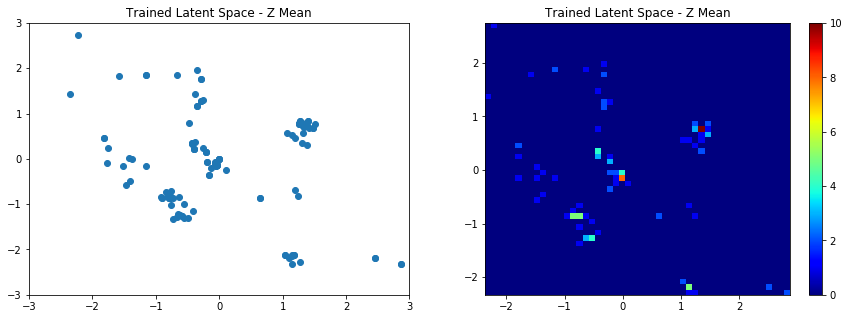

In [2]:
pluginTest = tfPlugin()
pluginTest.onSetup()
pluginTest.onBeginTraining()
pluginTest.onJsonInput({})
pluginTest.show_z_distribution("Trained Latent Space - Z Mean", z_mean=True)

# Testing Preparations
Create a simple json input and define a continuous dismantling and training routine.

In [3]:
json_test = {'damages_first': '26.5',
 'damages_last': '6.25',
 'distances_first': '14.0',
 'distances_last': '21.0',
 'firemode_Automatic': '0.0',
 'firemode_Semi-Automatic': '0.0',
 'firemode_Single-Action': '1.0',
 'hiprecoildec': '6.0',
 'hiprecoilright': '1.2000000476837158',
 'hiprecoilup': '11.0',
 'hipstandbasespreaddec': '4.5',
 'hipstandbasespreadinc': '0.30000001192092896',
 'hordispersion': '2.700000047683716',
 'initialspeed': '333.0',
 'magsize': '2.0',
 'reloadempty': '5.333333492279053',
 'rof': '299.0',
 'shotspershell': '12.0',
 'type_Pistol': '0.0',
 'type_Rifle': '-2.7755575615628914e-17',
 'type_Shotgun': '1.0',
 'type_Sniper Rifle': '0.0',
 'type_Submachine Gun': '0.0',
 'type_Light Machine Gun' : '0.0'}

def input_and_train():
    global pluginTest, json_test
    for _ in range(pluginTest._dismantled_weapons_needed_to_retrain):
        for key, value in json_test.items():
            if "type" not in key or "firemode" not in key:
                new_value = float(value) * np.random.uniform(low=0.8, high=1.5)
                json_test[key] = str(new_value)
        print(pluginTest.onJsonInput(json_test))
    pluginTest.onBeginTraining()
    pluginTest.show_z_distribution("Trained Latent Space - Z Mean", z_mean=True)

# Testing
Run the test routine so you can check the output and get a view of the new z mean.

Generated a new weapon based on a dismantled one!
{'damages_first': '31.741219365399175', 'damages_last': '19.59772192029625', 'distances_first': '7.695055853628558', 'distances_last': '41.509338967736326', 'firemode_Automatic': '0.09517299572119436', 'firemode_Semi': '0.12189785468275399', 'firemode_Single': '0.03963681162769239', 'hiprecoildec': '3.9496075607444485', 'hiprecoilright': '0.3824811236242589', 'hiprecoilup': '1.224065788139575', 'hipstandbasespreaddec': '4.28415176360576', 'hipstandbasespreadinc': '0.15249811578910982', 'initialspeed': '469.37697699703847', 'magsize': '4.670918012303666', 'reloadempty': '3.160698957319199', 'rof': '200.1248078891725', 'shotspershell': '0.2972440844100439', 'type_Shotgun': '-0.059979792739535825', 'type_Pistol': '-0.008357357648691027', 'type_Rifle': '0.006674392368004045', 'type_SMG': '-0.05232271712901519', 'type_Sniper': '0.006674392368003962', 'type_MG': '-0.04925056915812523'}
Generated a new weapon based on a dismantled one!
{'damag

Generated a random weapon!
{'damages_first': '88.084059859424', 'damages_last': '74.2598017747373', 'distances_first': '39.85688006838548', 'distances_last': '136.01174262387585', 'firemode_Automatic': '1.1548843776905342', 'firemode_Semi': '1.2017303160272592', 'firemode_Single': '1.0346988320330008', 'hiprecoildec': '10.25593006970908', 'hiprecoilright': '1.263638225911027', 'hiprecoilup': '7.420950731693663', 'hipstandbasespreaddec': '15.664349254436068', 'hipstandbasespreadinc': '1.0264774337226235', 'initialspeed': '930.648825469018', 'magsize': '84.32580250690603', 'reloadempty': '5.92818091389022', 'rof': '700.4148219686551', 'shotspershell': '6.581523053326425', 'type_Shotgun': '0.591441211500895', 'type_Pistol': '0.8902491831117575', 'type_Rifle': '0.9415078585044047', 'type_SMG': '0.6664256240694361', 'type_Sniper': '0.941507858504405', 'type_MG': '0.6897481662959342'}
Generated a random weapon!
{'damages_first': '27.604287199195873', 'damages_last': '15.584198384055796', 'di

Generated a random weapon!
Should retrain!
{'damages_first': '28.034490131555327', 'damages_last': '16.001567952860917', 'distances_first': '5.579167251185286', 'distances_last': '35.29213693764214', 'firemode_Automatic': '0.025455829803736063', 'firemode_Semi': '0.05085694660954965', 'firemode_Single': '-0.02582714880070025', 'hiprecoildec': '3.534722017220854', 'hiprecoilright': '0.3245108338409123', 'hiprecoilup': '0.8163800133786323', 'hipstandbasespreaddec': '3.535461950378281', 'hipstandbasespreadinc': '0.09500004399944523', 'initialspeed': '439.03044440321935', 'magsize': '-0.5694831883761253', 'reloadempty': '2.978629573123969', 'rof': '167.21131605367955', 'shotspershell': '-0.11619124053035845', 'type_Shotgun': '-0.1028360147330648', 'type_Pistol': '-0.0674756254739223', 'type_Rifle': '-0.054827202285727544', 'type_SMG': '-0.0996083254642856', 'type_Sniper': '-0.054827202285727655', 'type_MG': '-0.0978684271230906'}
Num of training samples = 147
Epoch:0010 - Cost:11.62
Epoch:

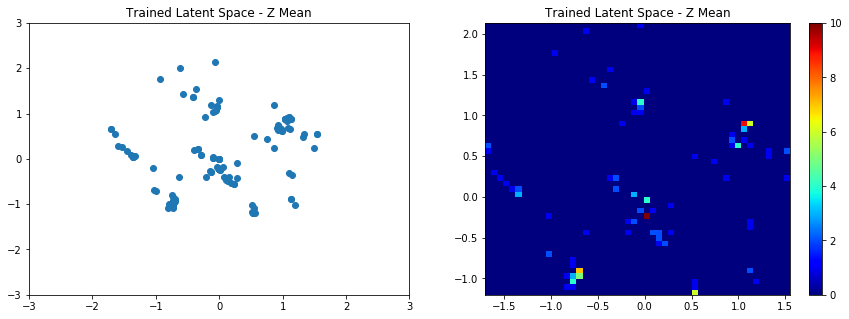

In [4]:
input_and_train()

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
Generated a random weapon!
{'damages_first': '56.40084621555774', 'damages_last': '36.50755484397712', 'distances_first': '19.61903235959982', 'distances_last': '171.01851063814652', 'firemode_Automatic': '0.42476084799895775', 'firemode_Semi': '0.4549803401732426', 'firemode_Single': '0.35475954526029796', 'hiprecoildec': '12.817861992069226', 'hiprecoilright': '2.3149275272908243', 'hiprecoilup': '7.042183234392943', 'hipstandbasespreaddec': '13.398273912880951', 'hipstandbasespreadinc': '0.7208415296318633', 'initialspeed': '823.34103502553', 'magsize': '31.163097449464882', 'reloadempty': '17.85006385380636', 'rof': '933.2886616132381', 'shotspershell': '17.095007099401094', 'type_Shotgun': '0.15663113623876296', 'type_Pistol': '0.2813847151688913', 'type_Rifle': '0.3062810392562383', 'type_SMG': '0.18495475917508952', 'type_Sniper': '0.3062810392562383', 'type_MG': '0.19415170469594664'}
Generated a random weapon!
{'

Generated a random weapon!
{'damages_first': '39.215369743656', 'damages_last': '22.754526178050156', 'distances_first': '11.703482759680002', 'distances_last': '60.32651243455653', 'firemode_Automatic': '0.16008092639702098', 'firemode_Semi': '0.1839522762604905', 'firemode_Single': '0.10859864006704187', 'hiprecoildec': '5.642576578536979', 'hiprecoilright': '0.6613109943069593', 'hiprecoilup': '2.932314539218898', 'hipstandbasespreaddec': '6.452486830948109', 'hipstandbasespreadinc': '0.3397145719978801', 'initialspeed': '538.4627910781679', 'magsize': '11.72548989593068', 'reloadempty': '2.537841186573665', 'rof': '302.21543288844475', 'shotspershell': '2.0413583901544747', 'type_Shotgun': '-0.0016151599569016184', 'type_Pistol': '0.06086094645913423', 'type_Rifle': '0.07628728133167043', 'type_SMG': '0.010006896193601178', 'type_Sniper': '0.07628728133167048', 'type_MG': '0.014152044229500893'}
Generated a random weapon!
{'damages_first': '48.45655102418704', 'damages_last': '30.1

Generated a random weapon!
Should retrain!
{'damages_first': '51.6640513227152', 'damages_last': '32.71683795274676', 'distances_first': '17.437286920057', 'distances_last': '140.5087198490129', 'firemode_Automatic': '0.3518077062614054', 'firemode_Semi': '0.38027747400261613', 'firemode_Single': '0.28691075908068026', 'hiprecoildec': '10.840153933926219', 'hiprecoilright': '1.8591448574902714', 'hiprecoilup': '5.9093892104749335', 'hipstandbasespreaddec': '11.483821972589162', 'hipstandbasespreadinc': '0.6157923487495662', 'initialspeed': '744.8206743466683', 'magsize': '25.805552644745845', 'reloadempty': '13.62958976646851', 'rof': '759.347342516226', 'shotspershell': '12.945803180546097', 'type_Shotgun': '0.11301405940900872', 'type_Pistol': '0.22060223624940084', 'type_Rifle': '0.24288836814211584', 'type_SMG': '0.13673426640962316', 'type_Sniper': '0.24288836814211584', 'type_MG': '0.14453879615629178'}
Num of training samples = 167
Epoch:0010 - Cost:11.81
Epoch:0020 - Cost:9.93


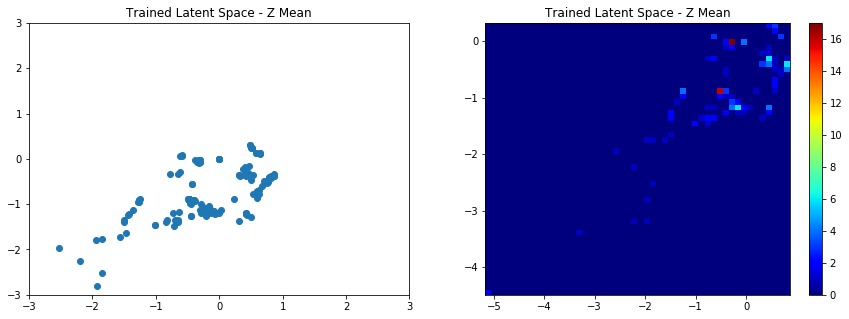

In [5]:
input_and_train()

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
Generated a random weapon!
{'damages_first': '-11.504825890626506', 'damages_last': '16.524089969063695', 'distances_first': '2.4829177722462887', 'distances_last': '-877.1985331072019', 'firemode_Automatic': '0.05431705909665707', 'firemode_Semi': '0.07255033152777926', 'firemode_Single': '0.016333994057812773', 'hiprecoildec': '-42.22392110642913', 'hiprecoilright': '-13.386787963379916', 'hiprecoilup': '-9.997301339576335', 'hipstandbasespreaddec': '-9.371499408620501', 'hipstandbasespreadinc': '-0.30266445865520386', 'initialspeed': '-2806.2704912886084', 'magsize': '9.712651753477754', 'reloadempty': '-42.87432565100818', 'rof': '-537.1279964419068', 'shotspershell': '-92.41665759641971', 'type_Shotgun': '-0.05075992447389467', 'type_Pistol': '-0.016453697789539173', 'type_Rifle': '-0.006205390354207335', 'type_SMG': '-0.045935582307529296', 'type_Sniper': '-0.006205390354207446', 'type_MG': '-0.04393777830387763'}
G

Generated a random weapon!
{'damages_first': '-3.3697677171103635', 'damages_last': '17.61465446215294', 'distances_first': '3.971347273854807', 'distances_last': '-759.1989977181315', 'firemode_Automatic': '0.06433204963133304', 'firemode_Semi': '0.08283915577230772', 'firemode_Single': '0.02558720871258341', 'hiprecoildec': '-37.01247807744271', 'hiprecoilright': '-11.914099241806493', 'hiprecoilup': '-8.23696920902945', 'hipstandbasespreaddec': '-7.197965320586903', 'hipstandbasespreadinc': '-0.20871025611771477', 'initialspeed': '-2427.267472245235', 'magsize': '10.754897659722321', 'reloadempty': '-37.49415663392206', 'rof': '-362.3733132992943', 'shotspershell': '-82.56623892304036', 'type_Shotgun': '-0.04488870762081297', 'type_Pistol': '-0.008211028424261052', 'type_Rifle': '0.0024067320010230375', 'type_SMG': '-0.03943519740883934', 'type_Sniper': '0.0024067320010229543', 'type_MG': '-0.03724633019873258'}
Generated a random weapon!
{'damages_first': '32.218392456277996', 'dam

Generated a random weapon!
{'damages_first': '30.855717318467796', 'damages_last': '22.202832929034894', 'distances_first': '10.233407181386731', 'distances_last': '-262.7561639334233', 'firemode_Automatic': '0.10646670944137565', 'firemode_Semi': '0.1261258776007024', 'firemode_Single': '0.06451695610257185', 'hiprecoildec': '-15.087107465710517', 'hiprecoilright': '-5.718263302198157', 'hiprecoilup': '-0.830971648026253', 'hipstandbasespreaddec': '1.9464386673884917', 'hipstandbasespreadinc': '0.18657003375717052', 'initialspeed': '-832.7414246089565', 'magsize': '15.139792138251675', 'reloadempty': '-14.858928924963536', 'rof': '372.8474638877901', 'shotspershell': '-41.123959137325315', 'type_Shotgun': '-0.020187563479033666', 'type_Pistol': '0.02646719402938502', 'type_Rifle': '0.03863930200932164', 'type_SMG': '-0.012087043120294044', 'type_Sniper': '0.038639302009321586', 'type_MG': '-0.009094342578710085'}
Generated a random weapon!
Should retrain!
{'damages_first': '-74.727473

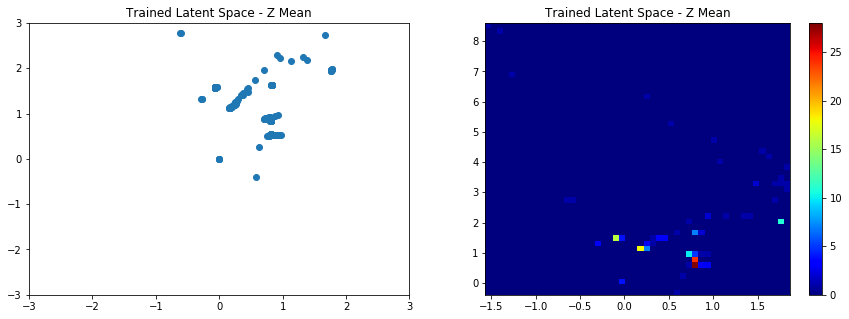

In [6]:
input_and_train()

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
Generated a random weapon!
{'damages_first': '1271.2291082608929', 'damages_last': '638.8495661704383', 'distances_first': '400.3283988422878', 'distances_last': '85451.44800071031', 'firemode_Automatic': '0.406508577760219', 'firemode_Semi': '0.4329933378670289', 'firemode_Single': '0.344600997042599', 'hiprecoildec': '1421.4660636585834', 'hiprecoilright': '1010.6767824578646', 'hiprecoilup': '665.3553754288708', 'hipstandbasespreaddec': '670.4625894883189', 'hipstandbasespreadinc': '141.0498846256647', 'initialspeed': '134319.47338240023', 'magsize': '211.85432471608158', 'reloadempty': '1466.357723872216', 'rof': '50707.99104818002', 'shotspershell': '6303.909788849693', 'type_Shotgun': '0.16308465982563825', 'type_Pistol': '0.2786889623925841', 'type_Rifle': '0.3011880895020357', 'type_SMG': '0.18985059911773777', 'type_Sniper': '0.3011880895020357', 'type_MG': '0.19846414593991746'}
Generated a random weapon!
{'dama

Generated a random weapon!
{'damages_first': '-17.0339215313694', 'damages_last': '-129.52381079687325', 'distances_first': '-45.97631549559975', 'distances_last': '-14873.414839531237', 'firemode_Automatic': '0.054443478731392214', 'firemode_Semi': '0.07045274844286847', 'firemode_Single': '0.02086988892698244', 'hiprecoildec': '-261.5470950155386', 'hiprecoilright': '-267.8584160868038', 'hiprecoilup': '-118.18016234327445', 'hipstandbasespreaddec': '-132.0657214852459', 'hipstandbasespreadinc': '-38.85495242927832', 'initialspeed': '-20175.61433552723', 'magsize': '4.144372670252281', 'reloadempty': '-212.895606062174', 'rof': '-6189.113715798587', 'shotspershell': '-1194.6668780580517', 'type_Shotgun': '-0.0403093999791027', 'type_Pistol': '-0.008473870922040827', 'type_Rifle': '0.0007491916577380409', 'type_SMG': '-0.0355932914781735', 'type_Sniper': '0.0007491916577380409', 'type_MG': '-0.03369546335086865'}
Generated a random weapon!
{'damages_first': '926.87692589462', 'damages

Generated a random weapon!
Should retrain!
{'damages_first': '1061.5039080666877', 'damages_last': '513.7607787243276', 'distances_first': '327.6713843991856', 'distances_last': '69118.87347435855', 'firemode_Automatic': '0.3491934785392781', 'firemode_Semi': '0.3739728615068807', 'firemode_Single': '0.2918985831034302', 'hiprecoildec': '1147.4767746161665', 'hiprecoilright': '802.5352428272837', 'hiprecoilup': '537.7982355293925', 'hipstandbasespreaddec': '539.8134853938011', 'hipstandbasespreadinc': '111.76193869016892', 'initialspeed': '109168.15532750852', 'magsize': '178.03979284818743', 'reloadempty': '1192.9805232130723', 'rof': '41445.31998556303', 'shotspershell': '5083.164912787839', 'type_Shotgun': '0.1299727417433969', 'type_Pistol': '0.23193974945044415', 'type_Rifle': '0.2522775746930512', 'type_SMG': '0.1531490374068407', 'type_Sniper': '0.2522775746930512', 'type_MG': '0.16066928618727055'}
Num of training samples = 207
Epoch:0010 - Cost:10.56
Epoch:0020 - Cost:8.39
Epo

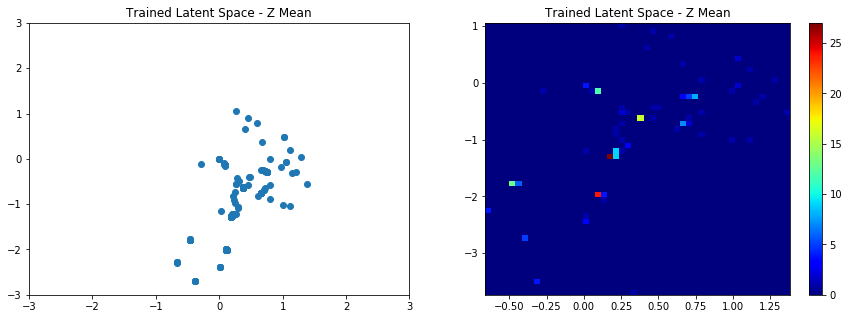

In [7]:
input_and_train()

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
Generated a random weapon!
{'damages_first': '11779.501777764566', 'damages_last': '7478.151123935995', 'distances_first': '2006.8350294749089', 'distances_last': '234153.20947160327', 'firemode_Automatic': '0.44818412714899014', 'firemode_Semi': '0.47494662866832216', 'firemode_Single': '0.38495454135748597', 'hiprecoildec': '34427.94191299594', 'hiprecoilright': '30789.80867369021', 'hiprecoilup': '17040.811478511183', 'hipstandbasespreaddec': '5368.4934060409505', 'hipstandbasespreadinc': '1307.4115068315107', 'initialspeed': '2668089.2340055024', 'magsize': '581.6588569878525', 'reloadempty': '39470.82462088563', 'rof': '560945.4124453379', 'shotspershell': '71127.1837287872', 'type_Shotgun': '0.19255916794982939', 'type_Pistol': '0.31646823659814977', 'type_Rifle': '0.33999436846474523', 'type_SMG': '0.22177591838040517', 'type_Sniper': '0.33999436846474507', 'type_MG': '0.231101501678253'}
Generated a random weapon!

Generated a random weapon!
{'damages_first': '12917.361115943238', 'damages_last': '8196.654585147333', 'distances_first': '2185.3207891704205', 'distances_last': '253735.57810741675', 'firemode_Automatic': '0.48267000980854197', 'firemode_Semi': '0.5105212582364784', 'firemode_Single': '0.41654962077422475', 'hiprecoildec': '37841.29405590016', 'hiprecoilright': '33979.9023143328', 'hiprecoilup': '18706.05278860815', 'hipstandbasespreaddec': '5851.125266358119', 'hipstandbasespreadinc': '1430.0413298150154', 'initialspeed': '2939314.387894755', 'magsize': '628.3339602625886', 'reloadempty': '43374.36327400339', 'rof': '616744.8290106088', 'shotspershell': '77947.20032533689', 'type_Shotgun': '0.21225748550551826', 'type_Pistol': '0.34440313956299573', 'type_Rifle': '0.3692513963616049', 'type_SMG': '0.24362923960730032', 'type_Sniper': '0.36925139636160476', 'type_MG': '0.25361266198342897'}
Generated a random weapon!
{'damages_first': '13324.270368522273', 'damages_last': '8453.59821

Generated a random weapon!
Should retrain!
{'damages_first': '13285.118793714873', 'damages_last': '8428.875876039858', 'distances_first': '2243.007628218553', 'distances_last': '260064.62614801386', 'firemode_Automatic': '0.4938158937480122', 'firemode_Semi': '0.5220190266500264', 'firemode_Single': '0.4267611931939834', 'hiprecoildec': '38944.49408719802', 'hiprecoilright': '35010.94489560181', 'hiprecoilup': '19244.261033320465', 'hipstandbasespreaddec': '6007.112536676566', 'hipstandbasespreadinc': '1469.67545453745', 'initialspeed': '3026974.724634817', 'magsize': '643.4194167984936', 'reloadempty': '44635.99224868865', 'rof': '634779.2759484022', 'shotspershell': '80151.4389177149', 'type_Shotgun': '0.21862400839391316', 'type_Pistol': '0.35343173800080596', 'type_Rifle': '0.37870730736644964', 'type_SMG': '0.25069226259823046', 'type_Sniper': '0.37870730736644953', 'type_MG': '0.2608882994546017'}
Num of training samples = 227
Epoch:0010 - Cost:10.73
Epoch:0020 - Cost:10.10
Epoc

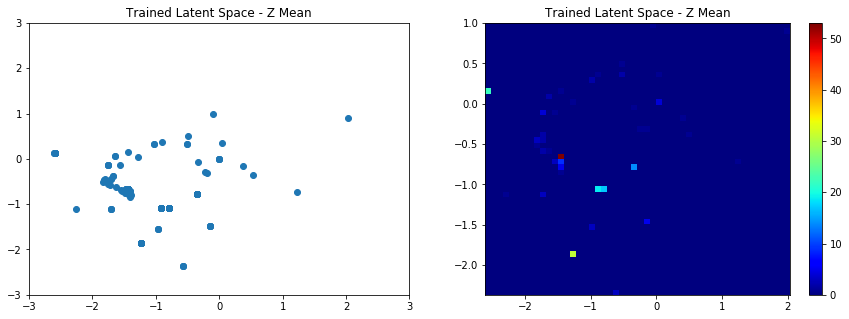

In [8]:
input_and_train()

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
Generated a random weapon!
{'damages_first': '54114.80250116308', 'damages_last': '117249.66814681876', 'distances_first': '32627.014385744213', 'distances_last': '2522345.027268694', 'firemode_Automatic': '0.4625229001138426', 'firemode_Semi': '0.4890075849214246', 'firemode_Single': '0.3996472903677546', 'hiprecoildec': '897703.9902904232', 'hiprecoilright': '1114224.4454669778', 'hiprecoilup': '204250.8610735492', 'hipstandbasespreaddec': '45472.77249068322', 'hipstandbasespreadinc': '16845.581630467415', 'initialspeed': '47545204.541280136', 'magsize': '8454.356141380857', 'reloadempty': '326987.1676535998', 'rof': '14054570.747170959', 'shotspershell': '916035.0584343477', 'type_Shotgun': '0.20495669295672364', 'type_Pistol': '0.33100101129907034', 'type_Rifle': '0.35465184366555913', 'type_SMG': '0.23493419467966742', 'type_Sniper': '0.35465184366555913', 'type_MG': '0.24446538238730914'}
Generated a random weapon!


Generated a random weapon!
{'damages_first': '43512.74053719293', 'damages_last': '92177.56432103184', 'distances_first': '25656.482584038687', 'distances_last': '1988778.612763617', 'firemode_Automatic': '0.38337405591324114', 'firemode_Semi': '0.4072477834251512', 'firemode_Single': '0.32734079191159193', 'hiprecoildec': '696930.4219313958', 'hiprecoilright': '865315.9839521488', 'hiprecoilup': '160825.376484392', 'hipstandbasespreaddec': '36067.35876962172', 'hipstandbasespreadinc': '13242.576543436116', 'initialspeed': '37820835.67640683', 'magsize': '6628.835768237796', 'reloadempty': '261036.45627328358', 'rof': '11063836.264106745', 'shotspershell': '719004.7005815983', 'type_Shotgun': '0.16015416214525452', 'type_Pistol': '0.26723674059073915', 'type_Rifle': '0.2878137140359243', 'type_SMG': '0.18519414047762048', 'type_Sniper': '0.2878137140359243', 'type_MG': '0.19321537726054716'}
Generated a random weapon!
{'damages_first': '60499.91248236711', 'damages_last': '132349.38562

Generated a random weapon!
Should retrain!
{'damages_first': '47585.91285240807', 'damages_last': '101809.93579126545', 'distances_first': '28334.46892797076', 'distances_last': '2193767.7889518356', 'firemode_Automatic': '0.41378199750750466', 'firemode_Semi': '0.43865882036153603', 'firemode_Single': '0.3551199945537449', 'hiprecoildec': '774064.9777419629', 'hiprecoilright': '960943.330586269', 'hiprecoilup': '177508.8746760137', 'hipstandbasespreaddec': '39680.79461936151', 'hipstandbasespreadinc': '14626.803557195206', 'initialspeed': '41556809.883872196', 'magsize': '7330.176608351422', 'reloadempty': '286373.849383789', 'rof': '12212836.990566822', 'shotspershell': '794701.1643063043', 'type_Shotgun': '0.17736670332573573', 'type_Pistol': '0.29173413204456167', 'type_Rifle': '0.31349204152857396', 'type_SMG': '0.204303612995475', 'type_Sniper': '0.31349204152857396', 'type_MG': '0.21290495300028284'}
Num of training samples = 247
Epoch:0010 - Cost:10.20
Epoch:0020 - Cost:8.90
Ep

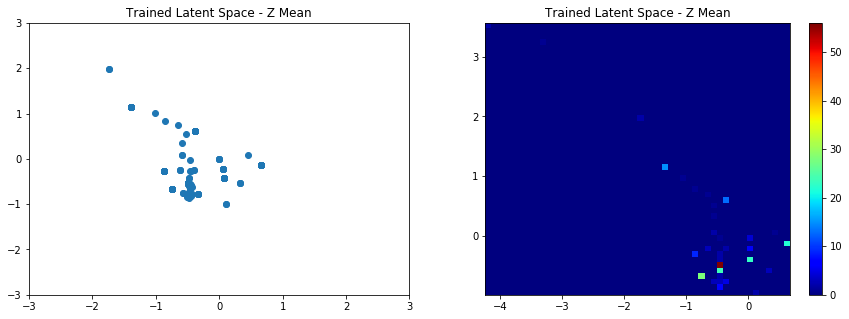

In [9]:
input_and_train()

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
Generated a random weapon!
{'damages_first': '353876.12402939843', 'damages_last': '2484084.3138802694', 'distances_first': '309861.5868299192', 'distances_last': '35673164.7957469', 'firemode_Automatic': '0.32779265902440535', 'firemode_Semi': '0.3490938834444958', 'firemode_Single': '0.278101811061237', 'hiprecoildec': '20070498.657803897', 'hiprecoilright': '27054967.072952967', 'hiprecoilup': '1255560.726787009', 'hipstandbasespreaddec': '546076.4772087677', 'hipstandbasespreadinc': '124426.91079418323', 'initialspeed': '438913041.4757598', 'magsize': '165957.49788789748', 'reloadempty': '1678446.9300800674', 'rof': '144912923.6866116', 'shotspershell': '3619804.411780626', 'type_Shotgun': '0.13267243379503688', 'type_Pistol': '0.22529589399939687', 'type_Rifle': '0.24331424415087194', 'type_SMG': '0.15414157223940847', 'type_Sniper': '0.2433142441508719', 'type_MG': '0.1610455334090752'}
Generated a random weapon!
{'

Generated a random weapon!
{'damages_first': '-30752.252709226945', 'damages_last': '-439455.4734389803', 'distances_first': '-50776.44093664024', 'distances_last': '-6658461.211091487', 'firemode_Automatic': '0.04830872805606723', 'firemode_Semi': '0.06007272148198428', 'firemode_Single': '0.023369263799308773', 'hiprecoildec': '-3753611.281897638', 'hiprecoilright': '-4952547.69643582', 'hiprecoilup': '-134308.22212283663', 'hipstandbasespreaddec': '-85823.74073347772', 'hipstandbasespreadinc': '-22154.15582584554', 'initialspeed': '-61398800.522116035', 'magsize': '-39203.91419511285', 'reloadempty': '-162613.13528440497', 'rof': '-26997230.37824914', 'shotspershell': '-122138.19591030758', 'type_Shotgun': '-0.024366392240670012', 'type_Pistol': '0.0011321886980917295', 'type_Rifle': '0.00818333040864476', 'type_SMG': '-0.020308883276424126', 'type_Sniper': '0.008183330408644773', 'type_MG': '-0.018737401997063335'}
Generated a random weapon!
{'damages_first': '-62111.067463981424',

Generated a random weapon!
{'damages_first': '142834.81130263512', 'damages_last': '879970.5463096267', 'distances_first': '111983.51177887862', 'distances_last': '12446272.390945245', 'firemode_Automatic': '0.1744429343428177', 'firemode_Semi': '0.1905111861833616', 'firemode_Single': '0.13833289535036716', 'hiprecoildec': '6998474.490335781', 'hiprecoilright': '9492799.686006945', 'hiprecoilup': '492955.09174977324', 'hipstandbasespreaddec': '199359.8552121482', 'hipstandbasespreadinc': '43999.50972023256', 'initialspeed': '164397497.9184312', 'magsize': '53387.712751379', 'reloadempty': '668277.7473019295', 'rof': '50587734.02552076', 'shotspershell': '1566642.1184224656', 'type_Shotgun': '0.046506976434185776', 'type_Pistol': '0.10229976190529812', 'type_Rifle': '0.11430052675548619', 'type_SMG': '0.05842254742377022', 'type_Sniper': '0.11430052675548619', 'type_MG': '0.062400636182041835'}
Generated a random weapon!
Should retrain!
{'damages_first': '149733.52221236782', 'damages_

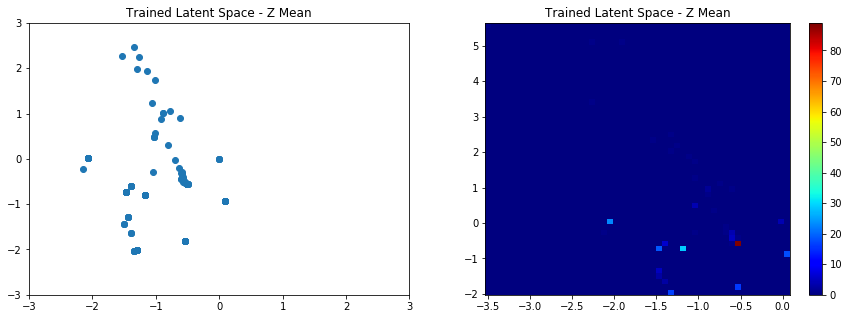

In [10]:
input_and_train()

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
Generated a random weapon!
{'damages_first': '2586557.768101452', 'damages_last': '17785225.785956398', 'distances_first': '749330.5039722868', 'distances_last': '623832181.4273708', 'firemode_Automatic': '0.193322449652396', 'firemode_Semi': '0.2093038201490487', 'firemode_Single': '0.15703852891055503', 'hiprecoildec': '112613934.00393306', 'hiprecoilright': '192204358.7541777', 'hiprecoilup': '6364751.240923408', 'hipstandbasespreaddec': '2751330.486837728', 'hipstandbasespreadinc': '1414728.9082430596', 'initialspeed': '2381936307.076252', 'magsize': '1003653.3723878175', 'reloadempty': '8872697.1810662', 'rof': '812597638.2379861', 'shotspershell': '34055536.900594205', 'type_Shotgun': '0.060875442476469616', 'type_Pistol': '0.12017615815909993', 'type_Rifle': '0.1325411504022516', 'type_SMG': '0.07388678342992074', 'type_Sniper': '0.1325411504022516', 'type_MG': '0.07817649178596506'}
Generated a random weapon!
{'da

Generated a random weapon!
{'damages_first': '1913687.0371724742', 'damages_last': '13733799.173493383', 'distances_first': '603124.7858011752', 'distances_last': '434824871.874179', 'firemode_Automatic': '0.16392532603380278', 'firemode_Semi': '0.17887614682248437', 'firemode_Single': '0.13029590088998028', 'hiprecoildec': '85939906.79639937', 'hiprecoilright': '144017974.56806278', 'hiprecoilup': '4886502.881342738', 'hipstandbasespreaddec': '2140992.2751164455', 'hipstandbasespreadinc': '1046975.6288188014', 'initialspeed': '1853637917.688768', 'magsize': '760690.9896622103', 'reloadempty': '6889342.146241231', 'rof': '623937228.8496592', 'shotspershell': '24543168.270195924', 'type_Shotgun': '0.04445870769214874', 'type_Pistol': '0.09668408935415672', 'type_Rifle': '0.107885665608198', 'type_SMG': '0.05564060284562022', 'type_Sniper': '0.107885665608198', 'type_MG': '0.059369344705382895'}
Generated a random weapon!
{'damages_first': '1601976.3813526523', 'damages_last': '11856955.

Generated a random weapon!
{'damages_first': '-1964822.2415275571', 'damages_last': '-9619119.873402437', 'distances_first': '-239622.87502033915', 'distances_last': '-654636402.2580723', 'firemode_Automatic': '-0.005523293858448547', 'firemode_Semi': '0.0034873122340027263', 'firemode_Single': '-0.02385188136148253', 'hiprecoildec': '-67812451.96927916', 'hiprecoilright': '-133734243.77382499', 'hiprecoilup': '-3634301.6585442796', 'hipstandbasespreaddec': '-1377071.9064507573', 'hipstandbasespreadinc': '-1072799.3011296708', 'initialspeed': '-1191538683.071885', 'magsize': '-639773.9324415271', 'reloadempty': '-4542959.114514634', 'rof': '-463524470.2581991', 'shotspershell': '-30287289.200407058', 'type_Shotgun': '-0.05016936165341293', 'type_Pistol': '-0.03872707158315723', 'type_Rifle': '-0.03423156753784869', 'type_SMG': '-0.04953261608655468', 'type_Sniper': '-0.03423156753784869', 'type_MG': '-0.04903735379554124'}
Generated a random weapon!
Should retrain!
{'damages_first': '-

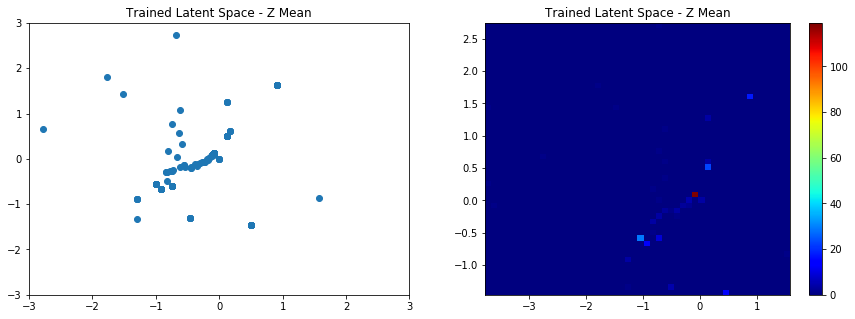

In [11]:
input_and_train()

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
Generated a random weapon!
{'damages_first': '-64424374.179771245', 'damages_last': '-18646777.49181108', 'distances_first': '-144362.48537025694', 'distances_last': '-7542847854.570091', 'firemode_Automatic': '0.03831010934791719', 'firemode_Semi': '0.04812650039871566', 'firemode_Single': '0.017502615546740458', 'hiprecoildec': '-684318297.6083581', 'hiprecoilright': '-215877251.29010224', 'hiprecoilup': '-3264339.4617898464', 'hipstandbasespreaddec': '-20381311.841993585', 'hipstandbasespreadinc': '-846596.3625582131', 'initialspeed': '-16733205027.108974', 'magsize': '-7737649.853531258', 'reloadempty': '-62780452.11621232', 'rof': '-3816172359.0947256', 'shotspershell': '-197043775.92423975', 'type_Shotgun': '-0.0220770395221591', 'type_Pistol': '-0.0010244984443015942', 'type_Rifle': '0.004844825015246426', 'type_SMG': '-0.018774451607203327', 'type_Sniper': '0.004844825015246398', 'type_MG': '-0.017484909556676212'

Generated a random weapon!
{'damages_first': '169551884.2899025', 'damages_last': '134462289.8761423', 'distances_first': '5396550.6278496785', 'distances_last': '26676117747.082367', 'firemode_Automatic': '0.22646535638218146', 'firemode_Semi': '0.2430240720443189', 'firemode_Single': '0.18839438689380184', 'hiprecoildec': '3126128867.9479074', 'hiprecoilright': '1977691914.6886582', 'hiprecoilup': '46935185.77208646', 'hipstandbasespreaddec': '76204497.0144229', 'hipstandbasespreadinc': '12421577.51990427', 'initialspeed': '66206625812.63565', 'magsize': '25987764.074236058', 'reloadempty': '230818959.0461367', 'rof': '14470419582.700287', 'shotspershell': '1023356142.7812018', 'type_Shotgun': '0.08245365327465322', 'type_Pistol': '0.1488727933504705', 'type_Rifle': '0.16224155695265602', 'type_SMG': '0.09745520116441109', 'type_Sniper': '0.16224155695265605', 'type_MG': '0.10233569199290002'}
Generated a random weapon!
{'damages_first': '150068560.195599', 'damages_last': '121712818

Generated a random weapon!
{'damages_first': '118691561.69694522', 'damages_last': '101180380.80907235', 'distances_first': '4192100.9531642464', 'distances_last': '19237809088.415924', 'firemode_Automatic': '0.1855653239416653', 'firemode_Semi': '0.20065843447359855', 'firemode_Single': '0.15124698281083598', 'hiprecoildec': '2297837256.9478526', 'hiprecoilright': '1500867316.5805373', 'hiprecoilup': '36023121.17156986', 'hipstandbasespreaddec': '55209266.86385717', 'hipstandbasespreadinc': '9537423.339923836', 'initialspeed': '48177674585.255165', 'magsize': '18656740.648329012', 'reloadempty': '166998121.5710609', 'rof': '10495392495.043804', 'shotspershell': '758073100.972827', 'type_Shotgun': '0.05973141302992227', 'type_Pistol': '0.11628904033913282', 'type_Rifle': '0.12802762168515344', 'type_SMG': '0.07218991282491949', 'type_Sniper': '0.12802762168515344', 'type_MG': '0.07628982525431587'}
Generated a random weapon!
Should retrain!
{'damages_first': '5441677.318447769', 'damag

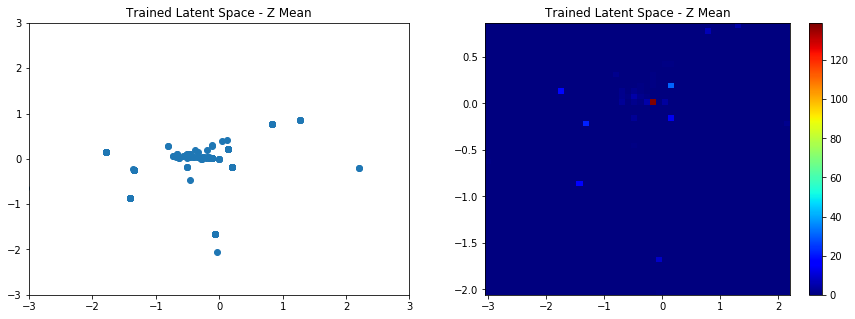

In [12]:
input_and_train()

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
Generated a random weapon!
{'damages_first': '882426255.0317814', 'damages_last': '537786900.922757', 'distances_first': '13566815.026984893', 'distances_last': '272184194102.49063', 'firemode_Automatic': '0.13055764439757062', 'firemode_Semi': '0.14312113596927398', 'firemode_Single': '0.10242862684851033', 'hiprecoildec': '25580433632.086678', 'hiprecoilright': '5179279095.80171', 'hiprecoilup': '806633331.7005477', 'hipstandbasespreaddec': '450944736.53406215', 'hipstandbasespreadinc': '39438864.391457014', 'initialspeed': '269053089567.46613', 'magsize': '134766774.01888233', 'reloadempty': '954056869.2759285', 'rof': '52497281900.94736', 'shotspershell': '16341251918.111172', 'type_Shotgun': '0.03202782120189475', 'type_Pistol': '0.07454792108804376', 'type_Rifle': '0.0838080606889127', 'type_SMG': '0.04100671206823041', 'type_Sniper': '0.0838080606889127', 'type_MG': '0.044020390449424185'}
Generated a random weapon

Generated a random weapon!
{'damages_first': '1346686763.3697505', 'damages_last': '776506413.1985698', 'distances_first': '19222117.08235607', 'distances_last': '443016598296.60925', 'firemode_Automatic': '0.16629311487062082', 'firemode_Semi': '0.18016069370217808', 'firemode_Single': '0.13484121910027366', 'hiprecoildec': '42172826290.73111', 'hiprecoilright': '7235986874.545198', 'hiprecoilup': '1495885082.1880019', 'hipstandbasespreaddec': '670015463.5605332', 'hipstandbasespreadinc': '55521445.2751895', 'initialspeed': '392401267180.64606', 'magsize': '206971790.288956', 'reloadempty': '1463528260.343223', 'rof': '79048369529.37227', 'shotspershell': '26109500506.80432', 'type_Shotgun': '0.051792825934859135', 'type_Pistol': '0.10294247993240666', 'type_Rifle': '0.11363554930129294', 'type_SMG': '0.06299200957564022', 'type_Sniper': '0.11363554930129291', 'type_MG': '0.06668779405187326'}
Generated a random weapon!
{'damages_first': '1563863935.7088978', 'damages_last': '88817739

Generated a random weapon!
{'damages_first': '2561722139.6728597', 'damages_last': '1401269121.246497', 'distances_first': '34022841.97182583', 'distances_last': '890109148248.4614', 'firemode_Automatic': '0.2598178925197736', 'firemode_Semi': '0.27709845205085487', 'firemode_Single': '0.21966955473572933', 'hiprecoildec': '85597463311.73915', 'hiprecoilright': '12618681859.387505', 'hiprecoilup': '3299754343.045849', 'hipstandbasespreaddec': '1243354523.1383362', 'hipstandbasespreadinc': '97611832.81632802', 'initialspeed': '715220883992.4851', 'magsize': '395942524.47601026', 'reloadempty': '2796886907.576006', 'rof': '148536319007.0291', 'shotspershell': '51674387863.419525', 'type_Shotgun': '0.10352063722193874', 'type_Pistol': '0.17725505416778808', 'type_Rifle': '0.1916983032927165', 'type_SMG': '0.12053064090502566', 'type_Sniper': '0.19169830329271642', 'type_MG': '0.1260115934517278'}
Generated a random weapon!
Should retrain!
{'damages_first': '-611140897.4567214', 'damages_l

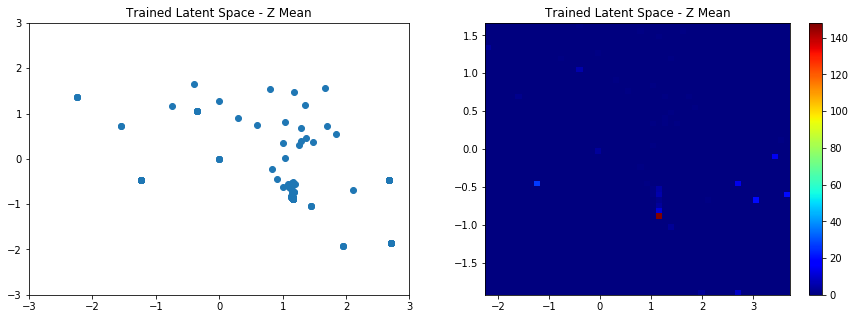

In [13]:
input_and_train()

In [14]:
pluginTest.onJsonInput(json_test)

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
Generated a random weapon!


{'damages_first': '-34663143555.45942',
 'damages_last': '-13088548063.17237',
 'distances_first': '-350203015.5414869',
 'distances_last': '-17273965876768.6',
 'firemode_Automatic': '-0.31390537269655755',
 'firemode_Semi': '-0.3182921863055991',
 'firemode_Single': '-0.2992520176417134',
 'hiprecoildec': '-1847939444736.2964',
 'hiprecoilright': '-387541543733.8692',
 'hiprecoilup': '-58165559528.17125',
 'hipstandbasespreaddec': '-21391682125.99459',
 'hipstandbasespreadinc': '-1831380057.7201385',
 'initialspeed': '-19575050578504.555',
 'magsize': '-7962093142.667588',
 'reloadempty': '-182545467969.7403',
 'rof': '-4558136586059.896',
 'shotspershell': '-1875006635028.947',
 'type_MG': '-0.23456587484641891',
 'type_Pistol': '-0.2760190605567708',
 'type_Rifle': '-0.2849204095529406',
 'type_SMG': '-0.2290627686538046',
 'type_Shotgun': '-0.21039091643133442',
 'type_Sniper': '-0.2849204095529406'}